In [1]:
from statistics import LinearRegression
from turtledemo.sorting_animate import disable_keys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import VotingClassifier, GradientBoostingRegressor, HistGradientBoostingClassifier, \
    HistGradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import root_mean_squared_error, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

## 04.Stacking계열


**Stacking(스태킹) 앙상블**은 여러 개의 서로 다른 예측 모델(=base learner, 기본 모델)의 예측 결과를 **다시 하나의 모델(=meta learner, 메타 모델)이 학습**해서 최종 예측을 하는 방법이다.


Voting/Bagging/Boosting과는 다르게, 메타 모델이 base 모델의 예측 결과 자체를 학습하는 구조다.


* 일반적인 Voting이나 Averaging은 기본 모델들의 예측 결과를 단순 집계(평균, 다수결 등)하지만,
* **Stacking은 여러 모델의 예측 결과 자체를 새로운 특성(Feature)으로 만들어, 최종 메타 모델이 학습**하는 방식이다.


**구조**


1. **1단계(Base models)**: 서로 다른 여러 개의 모델(예: 로지스틱 회귀, 결정트리, SVM 등)이 각각 학습하고 예측한다.
2. **2단계(Meta model)**: 1단계에서 나온 예측값(각 모델의 output)을 입력 데이터로 사용해 메타 모델을 다시 학습한다.


**장점**


* 서로 다른 모델이 가진 다양한 예측 능력을 종합하여 더 좋은 성능을 기대할 수 있다.
* Voting보다 유연하게 모델 간 관계를 학습한다.


**단점**


* 구현 복잡도와 연산량이 많아질 수 있다.
* 과적합(overfitting)이 일어날 가능성이 있다(특히 meta model이 너무 강력하면).

### stackingRegressor

In [2]:
# 캘리포니아 집값 예측
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(as_frame=True, return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



(16512, 8) (16512,)
(4128, 8) (4128,)


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

# 1단계
base_learners = [
    ('lr', LinearRegression()),
    ('knn', KNeighborsRegressor()),
    ('dt', DecisionTreeRegressor(random_state=42)),
]

meta_learner = RandomForestRegressor(random_state=42)

# 2단계
stack_reg = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_learner, # 원래는 예측값만 보는데 밑에 다른 특성도 봄
    passthrough=True # 메타모델이 원본 학습데이터(특성)도 학습할지 여부
)

stack_reg.fit(X_train, y_train)

# 평가
print('Train R2 :', stack_reg.score(X_train, y_train))
print('Test R2 :', stack_reg.score(X_test, y_test))


Train R2 : 0.8953618528823498
Test R2 : 0.7826734850905247


### StackingClassifier

In [4]:
from sklearn.datasets import load_digits

# 손글씨 Dataset
digits = load_digits()
X, y = digits.data, digits.target

print(X.shape, y.shape)
print(X[0])

X[0].reshape(8, 8)


(1797, 64) (1797,)
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

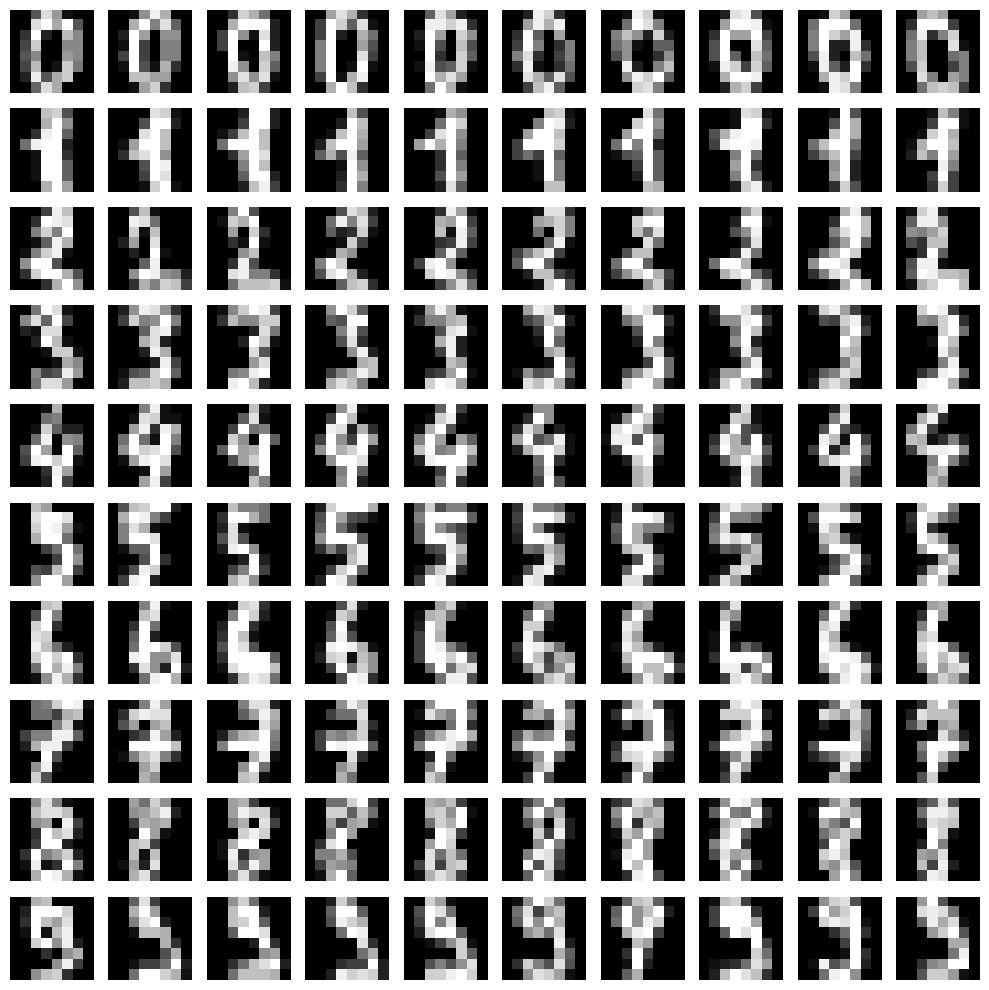

In [5]:
# 시각화

# 숫자별 10개씩 가져오기
class_images = {i:[] for i in range(10)}


# 데이터셋 순회
for img, label in zip(X, y):
    # 10개씩만 담기
    # 왜 ? 데이터가 총 1797개가 있는데 너무 많으니까 10개씩만 담아준다.
    if len(class_images[label]) < 10:
        class_images[label].append(img)

# 시각화
fig, ax = plt.subplots(10, 10, figsize=(10, 10)) # 10 행 10 열짜리 사이즈 지정해줌


for i in range(10) :  # i : 0~9(숫자 클래스)
    for j in range(10) : #j : 각 숫자에서 몇 번째 이미지인지(0~9)
        ax[i, j].imshow(class_images[i][j].reshape(8, 8), cmap='gray')
        ax[i, j].axis('off') # 눈금 지우기



plt.tight_layout() # 이미지가 겹치면 안겹치게 해줄 수 있음
plt.show()





In [6]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                    stratify=y)


In [7]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

# 모델 학습
base_learners = [
    ('knn', KNeighborsRegressor()),
    ('dt', DecisionTreeRegressor()),        # 거리를 찾는 모델, 차이에 민감
    ('svc', make_pipeline(StandardScaler(), SVC(random_state=42, kernel='rbf'))), # 스케일링 필수
]

meta_learner = LogisticRegression(random_state=42, solver='liblinear')

stack_clf = StackingClassifier( # 얘는 판단을 하는 게 아니라 묶어만 줌
    estimators=base_learners,
    final_estimator=meta_learner, # 최종적으로 판단하는 모델 마음대로 정해줄 수 있음
    passthrough=True
)

stack_clf.fit(X_train, y_train)


print('Train Accuracy : ', stack_clf.score(X_train, y_train))
print('Trest Accuracy : ', stack_clf.score(X_test, y_test))

C:\Users\TJ\anaconda3\envs\ai_env2\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Train Accuracy :  1.0
Trest Accuracy :  0.9722222222222222


In [8]:
from sklearn.metrics import classification_report
print(classification_report(y_test, stack_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.94      0.94      0.94        36
           2       1.00      1.00      1.00        35
           3       0.97      1.00      0.99        37
           4       0.92      1.00      0.96        36
           5       1.00      1.00      1.00        37
           6       1.00      0.97      0.99        36
           7       0.97      0.97      0.97        36
           8       0.92      0.94      0.93        35
           9       1.00      0.92      0.96        36

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360

